D:\Descargas\Anaconda\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


🔍 XGBoost -> MAE: 8.90 KJ | RMSE: 11.67 KJ | R²: 0.89


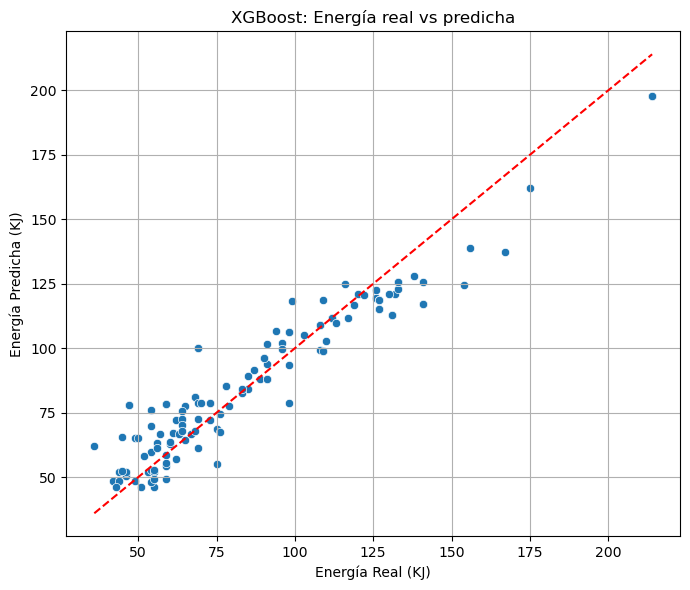

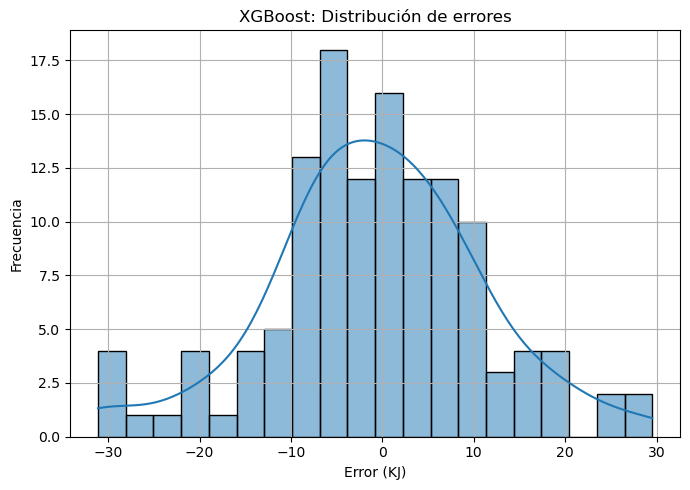

✅ Modelo guardado como modelo_xgboost_tecar.pkl

📊 Validación cruzada 5-Fold:
Promedio R²: 0.8305
Promedio MAE: 9.81 KJ
Promedio RMSE: 14.09 KJ


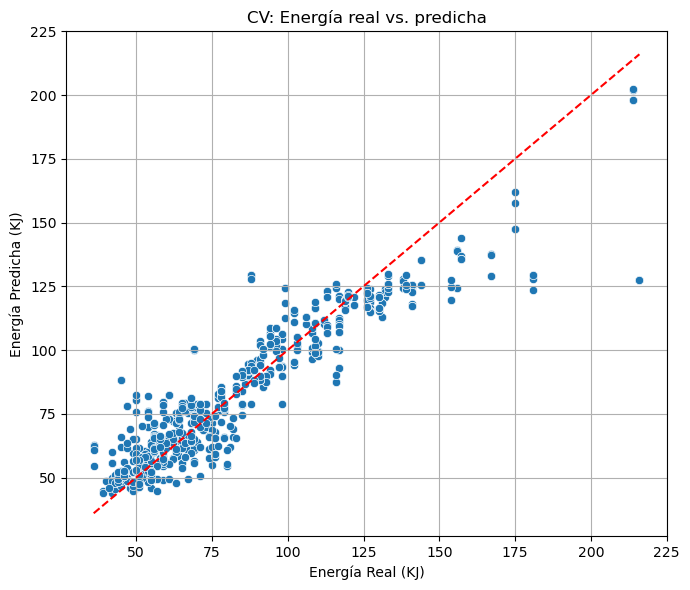

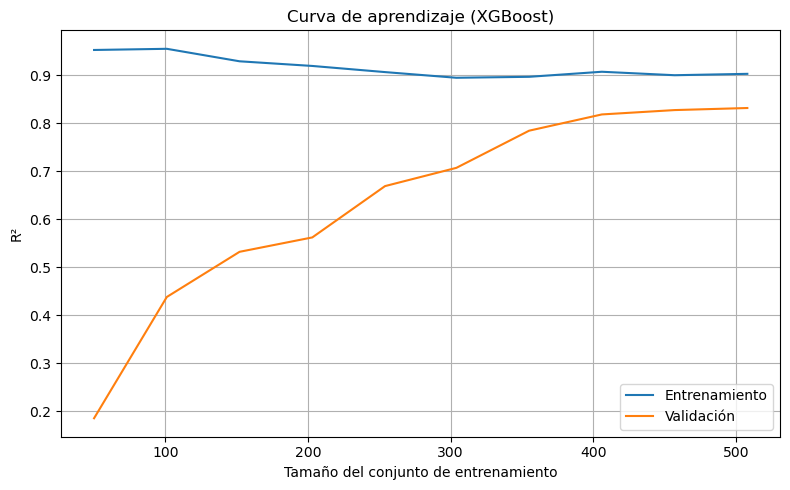

In [1]:
# === Paso 1: Librerías necesarias ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, learning_curve, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# === Paso 2: Cargar el dataset ===
df = pd.read_csv("TFG_TECAR_IA_datos_formato_filas.1.csv", encoding="utf-8-sig")
df.columns = df.columns.str.strip()

# === Paso 3: Definir variables predictoras y objetivo ===
features = [
    'Edad', 'Plicometro Antes (mm)', 'Trocanter antes (cm)',
    'IMC antes', 'Altura (cm)', 'Duración', 'Sexo'
]
X = df[features]
y = df["Energia (KJ)"]

# === Paso 4: Dividir en entrenamiento y prueba ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Paso 5: Entrenar modelo XGBoost ===
model = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# === Paso 6: Predicciones ===
y_pred = model.predict(X_test)

# === Paso 7: Evaluación ===
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"🔍 XGBoost -> MAE: {mae:.2f} KJ | RMSE: {rmse:.2f} KJ | R²: {r2:.2f}")

# === Paso 8: Gráfico real vs predicho ===
plt.figure(figsize=(7, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Energía Real (KJ)")
plt.ylabel("Energía Predicha (KJ)")
plt.title("XGBoost: Energía real vs predicha")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Paso 9: Histograma de errores ===
errores = y_test - y_pred
plt.figure(figsize=(7, 5))
sns.histplot(errores, bins=20, kde=True)
plt.title("XGBoost: Distribución de errores")
plt.xlabel("Error (KJ)")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Paso 10: Guardar el modelo ===
joblib.dump(model, "modelo_xgboost_tecar.pkl")
print("✅ Modelo guardado como modelo_xgboost_tecar.pkl")

# === Paso 11: VALIDACIÓN CRUZADA ===
cv = KFold(n_splits=5, shuffle=True, random_state=42)

r2_cv = cross_val_score(model, X, y, cv=cv, scoring='r2')
mae_cv = -cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error')
rmse_cv = np.sqrt(-cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error'))

print("\n📊 Validación cruzada 5-Fold:")
print(f"Promedio R²: {np.mean(r2_cv):.4f}")
print(f"Promedio MAE: {np.mean(mae_cv):.2f} KJ")
print(f"Promedio RMSE: {np.mean(rmse_cv):.2f} KJ")

# === Paso 12: Reales vs. predichos (CV) ===
y_pred_cv = cross_val_predict(model, X, y, cv=cv)
plt.figure(figsize=(7, 6))
sns.scatterplot(x=y, y=y_pred_cv)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Energía Real (KJ)")
plt.ylabel("Energía Predicha (KJ)")
plt.title("CV: Energía real vs. predicha")
plt.grid(True)
plt.tight_layout()
plt.show()

# === Paso 13: Curva de aprendizaje ===
train_sizes, train_scores, val_scores = learning_curve(
    model, X, y, cv=cv, scoring='r2',
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True, random_state=42
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label="Entrenamiento")
plt.plot(train_sizes, val_mean, label="Validación")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("R²")
plt.title("Curva de aprendizaje (XGBoost)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


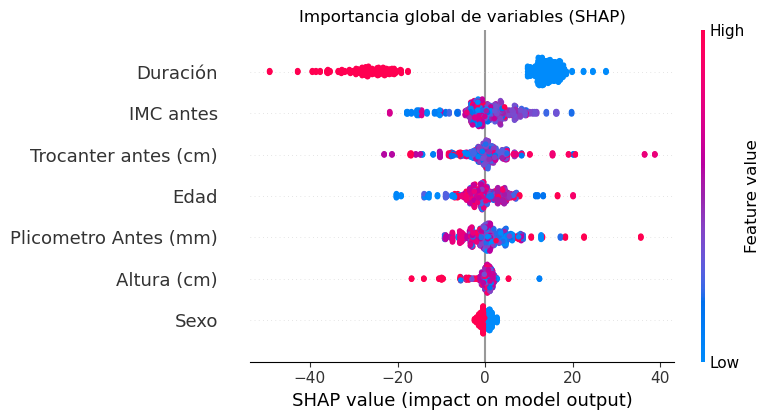

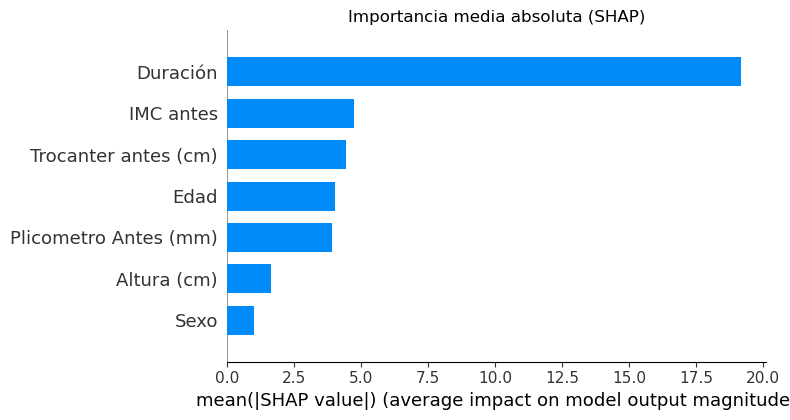

<Figure size 640x480 with 0 Axes>

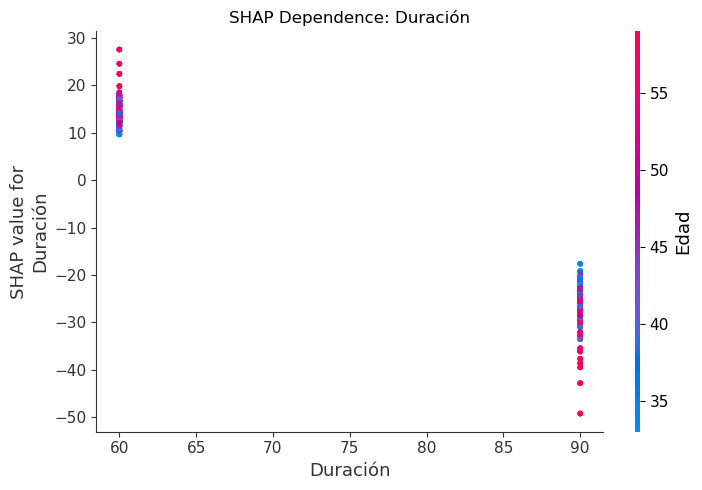

<Figure size 640x480 with 0 Axes>

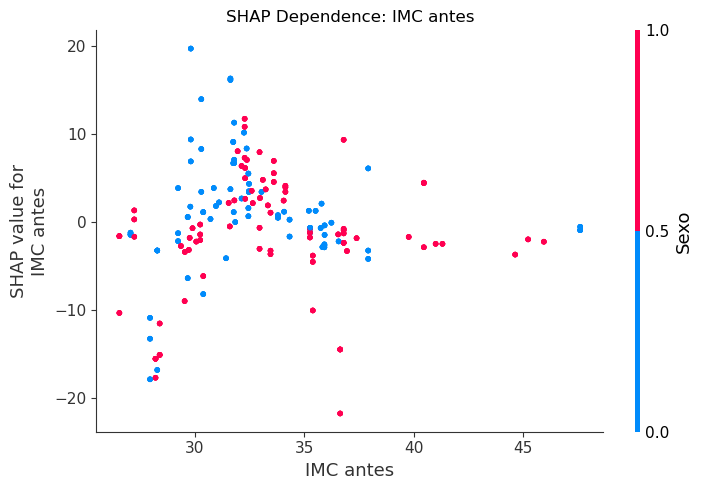

<Figure size 640x480 with 0 Axes>

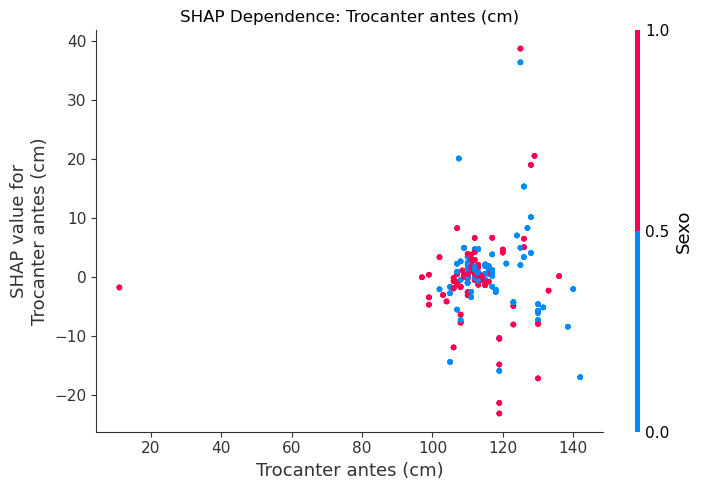

In [5]:
# === Instalar shap si no lo tienes ===
# !pip install shap

# === Importar librerías ===
import shap
import matplotlib.pyplot as plt

# === 1. Crear el explainer ===
# Para XGBoost puedes usar TreeExplainer
explainer = shap.TreeExplainer(model)

# === 2. Calcular los valores SHAP ===
# Dependiendo de la versión de shap, usa uno u otro:
try:
    # shap >= 0.40
    shap_values = explainer(X)
    shap_vals = shap_values.values
except AttributeError:
    # shap < 0.40
    shap_vals = explainer.shap_values(X)

# === 3. Gráfico summary plot ===
plt.figure()
shap.summary_plot(shap_vals, X, show=False)
plt.title("Importancia global de variables (SHAP)")
plt.tight_layout()
plt.show()

# === 4. Gráfico bar plot (opcional) ===
plt.figure()
shap.summary_plot(shap_vals, X, plot_type="bar", show=False)
plt.title("Importancia media absoluta (SHAP)")
plt.tight_layout()
plt.show()

# === 5. Dependence plots para las 3 variables top ===
top_feats = list(X.columns[np.argsort(np.abs(shap_vals).mean(axis=0))][-3:])[::-1]
for feat in top_feats:
    plt.figure()
    shap.dependence_plot(feat, shap_vals, X, show=False)
    plt.title(f"SHAP Dependence: {feat}")
    plt.tight_layout()
    plt.show()